# Segmentação de painéis solares utilizando imagens de satélite
---
# Solar Panel Segmentation Using Satellite Imagery

This script used is to evaluate the segmentation models.

## Library Imports

In this section, a connection is established with Google Drive files. Ensure that you have a direct access shortcut to the folder named "Segmentacao_de_paineis_solares_utilizando_imagens_de_satelite." Additionally, the necessary Python libraries are imported for the proper functioning of the code.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import sklearn.model_selection
import sklearn.utils.class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import json


## Config

In this section, it is possible to define the dataset, input the parameters (batch size, learning rate, probability of data augmentation, and epochs) for load the previusly trained model (with *train_model.ipynb*), and the file paths to load and save results. Finally, the satellite images and mask of the dataset are unzipped in the Google Colab environment.

In [13]:
## PARAMETER SETTINGS
db = 'google' # dataset; options: google, ign.
opt_databalance = '9010' # (masked/unmasked); options: 9010, 8020, 7030.
batch_size = 8 # maximum 16 due to limitations of free colab.
learning_rate = 1e-4
num_epochs = 5  # maximum 10 due to limitations of free colab.

## FILE PATHS
origin_dataset_path = "/content/gdrive/MyDrive/Segmentacao_de_paineis_solares_utilizando_imagens_de_satelite/data/raw/bdappv.zip"
dataset_path = "/content/"
image_folder = f'{dataset_path}bdappv/{db}/img'
mask_folder = f'{dataset_path}bdappv/{db}/mask'
black_mask = '/content/gdrive/MyDrive/Segmentacao_de_paineis_solares_utilizando_imagens_de_satelite/data/interim/empty_mask.png'
path_dic_dataset = f'/content/gdrive/MyDrive/Segmentacao_de_paineis_solares_utilizando_imagens_de_satelite/data/interim/jsons/output_google_{opt_databalance}.json'
model_unet_resnet50 = f'/content/gdrive/MyDrive/Segmentacao_de_paineis_solares_utilizando_imagens_de_satelite/data/processed/model_bs{batch_size}_lr{str(learning_rate)}_d{opt_databalance}.h5' #path to load the model
model_results_path = f'/content/gdrive/MyDrive/Segmentacao_de_paineis_solares_utilizando_imagens_de_satelite/data/results/model_bs{batch_size}_lr{str(learning_rate)}_d{opt_databalance}.json' #path to save the metrics
path_save_imgs_test = f'/content/gdrive/MyDrive/Segmentacao_de_paineis_solares_utilizando_imagens_de_satelite/assets/model_bs{batch_size}_lr{str(learning_rate)}_d{opt_databalance}.svg' #path to save the metrics

In [4]:
with zipfile.ZipFile(origin_dataset_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

## Fuctions

In this section, the functions used for loading, pre-processing data set, computing metrics (confusion matrix and dice score), and plotting results are presented.

### Loading & Pre-processing

In [7]:
def read_dataset_as_dataframe(path_dic_dataset, name_ds): #path_save_df
    """
    Read a JSON file containing dataset data and create a DataFrame from it.

    Args:
        path_dic_dataset (str): Path to the JSON file containing the dataset data.
        name_ds (str): Name of the dataset in the 'query' key in the JSON file.
        # path_save_df (str): Path to save the resulting DataFrame in CSV format.

    Returns:
        pandas.DataFrame: DataFrame with the randomized dataset data.
    """
    with open(path_dic_dataset, 'r') as file:
        data = json.load(file)
    query = data[name_ds]
    img_files = []
    mask_files = []
    for label in query.keys():
        files_query = query[label][0]
        for file_i in files_query:
            img_files.append(file_i[0])
            mask_files.append(file_i[1])
    df = pd.DataFrame()
    df['imgs'] = img_files
    df['masks'] = mask_files
    df_random = df.sample(frac=1).reset_index(drop=True)
    #df_random.to_csv(f'{path_save_df}df_random_{name_ds}.csv', index=False)
    return df_random

def load_and_preprocess_image(path):
    """
    Loads and preprocesses an image from the given file path.

    Args:
        path (str): File path of the image to be loaded and preprocessed.

    Returns:
        tf.Tensor: Preprocessed image tensor ready for further processing or analysis.
                   The tensor has the shape (height, width, channels) and the pixel values are normalized to the range [0, 1].
    """
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image


def load_and_preprocess_mask(path):
    """
    Loads and preprocesses a mask from the given file path.

    Args:
        path (str): File path of the mask to be loaded and preprocessed.

    Returns:
        tf.Tensor: Preprocessed mask tensor ready for further processing or analysis.
                   The tensor has the shape (height, width, 1) and the pixel values are normalized to the range [0, 1].
    """
    mask = tf.io.read_file(path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    return mask


def data_augmentation(image, mask, size=400, zoom_range=(0.7, 1.2)):
    """
    Applies random data augmentation operations to the given image and mask.

    Args:
        image (tf.Tensor): Image tensor to be augmented.
                           The tensor has the shape (height, width, channels) and the pixel values are normalized to the range [0, 1].
        mask (tf.Tensor): Mask tensor to be augmented.
                          The tensor has the shape (height, width, 1) and the pixel values are normalized to the range [0, 1].
        size (int): Desired size for the augmented image and mask (both height and width).
        zoom_range (tuple): Range for random zooming. It is specified as a tuple (min_zoom, max_zoom), where values should be between 0 and 1.

    Returns:
        tf.Tensor: Augmented image tensor.
                   The tensor has the shape (size, size, channels) and the pixel values are normalized to the range [0, 1].
        tf.Tensor: Augmented mask tensor.
                   The tensor has the shape (size, size, 1) and the pixel values are normalized to the range [0, 1].
    """
    # Apply random rotation and flip
    combined = tf.concat([image, mask], axis=-1)
    combined = tf.image.random_flip_left_right(combined)
    combined = tf.image.random_flip_up_down(combined)

    rotation_angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32) * 90
    combined = tf.image.rot90(combined, k=rotation_angle // 90)

    # Perform random zoom
    zoom_factor = tf.random.uniform([], zoom_range[0], zoom_range[1])
    combined_dims = tf.cast(tf.shape(combined)[:2], tf.float32)
    new_dims = tf.cast(combined_dims * zoom_factor, tf.int32)
    combined_resized = tf.image.resize(combined, new_dims)
    combined = tf.image.resize_with_crop_or_pad(combined_resized, size, size)

    # Split image and mask
    image = combined[:, :, :3]
    mask = combined[:, :, 3:]

    # Apply random brightness, contrast, and saturation adjustments
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.clip_by_value(image, 0, 1)  # Ensure values are in the [0, 1] range

    return image, mask


def random_augmentation(image, mask, augment_prob, size=400, zoom_range=(0.7, 1.2)):
    """
    Applies random data augmentation operations to the given image and mask with a given probability.

    Args:
        image (tf.Tensor): Image tensor to be augmented.
                           The tensor has the shape (height, width, channels) and the pixel values are normalized to the range [0, 1].
        mask (tf.Tensor): Mask tensor to be augmented.
                          The tensor has the shape (height, width, 1) and the pixel values are normalized to the range [0, 1].
        augment_prob (float): Probability of applying data augmentation operations.
                              Should be a value between 0 and 1.
        size (int): Desired size for the augmented image and mask (both height and width).
        zoom_range (tuple): Range for random zooming. It is specified as a tuple (min_zoom, max_zoom), where values should be between 0 and 1.

    Returns:
        tf.Tensor: Augmented image tensor.
                   The tensor has the shape (size, size, channels) and the pixel values are normalized to the range [0, 1].
        tf.Tensor: Augmented mask tensor.
                   The tensor has the shape (size, size, 1) and the pixel values are normalized to the range [0, 1].
    """
    if tf.random.uniform(shape=[], minval=0, maxval=1) < augment_prob:
        return data_augmentation(image, mask, size, zoom_range)
    else:
        return image, mask


def tf_data_generator(image_files, mask_files, batch_size, size=400, zoom_range=(0.7, 1.2)):
    """
    Generates batches of preprocessed image and mask data using TensorFlow's tf.data API.

    Args:
        image_files (list): List of image file paths.
        mask_files (list): List of mask file paths.
        batch_size (int): Batch size.
        size (int): Desired size for resizing the image and mask (both height and width).
        zoom_range (tuple): Range for random zooming. It is specified as a tuple (min_zoom, max_zoom), where values should be between 0 and 1.

    Returns:
        tf.data.Dataset: Dataset containing batches of preprocessed image and mask data.
    """
    # Convert the lists of file paths to tf.data Datasets
    image_dataset = tf.data.Dataset.from_tensor_slices(image_files)
    mask_dataset = tf.data.Dataset.from_tensor_slices(mask_files)

    # Use map to load and preprocess the image and mask data in parallel
    image_dataset = image_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    mask_dataset = mask_dataset.map(load_and_preprocess_mask, num_parallel_calls=tf.data.AUTOTUNE)

    # Combine the image and mask datasets
    dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))

    # Batch the data
    dataset = dataset.batch(batch_size)

    # Prefetch data for improved performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

def tf_data_generator_train(image_files, mask_files, batch_size, num_epochs, augment_prob, size=400, zoom_range=(0.7, 1.2)):
    """
    Generates batches of preprocessed image and mask data using TensorFlow's tf.data API.

    Args:
        image_files (list): List of image file paths.
        mask_files (list): List of mask file paths.
        batch_size (int): Batch size.
        num_epochs (int): Number of epochs.
        augment_prob (float): Probability of applying data augmentation operations.
                              Should be a value between 0 and 1.
        size (int): Desired size for resizing the image and mask (both height and width).
        zoom_range (tuple): Range for random zooming. It is specified as a tuple (min_zoom, max_zoom), where values should be between 0 and 1.

    Returns:
        tf.data.Dataset: Dataset containing batches of preprocessed image and mask data.
    """

    # Convert the lists of file paths to tf.data Datasets
    image_dataset = tf.data.Dataset.from_tensor_slices(image_files)
    mask_dataset = tf.data.Dataset.from_tensor_slices(mask_files)

    # Use map to load and preprocess the image and mask data in parallel
    image_dataset = image_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    mask_dataset = mask_dataset.map(load_and_preprocess_mask, num_parallel_calls=tf.data.AUTOTUNE)

    # Combine the image and mask datasets
    dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))

    # Apply random data augmentation
    dataset = dataset.map(lambda image, mask: random_augmentation(image, mask, augment_prob, size, zoom_range), num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle the dataset
    dataset = dataset.shuffle(buffer_size=100)

    # Repeat the dataset indefinitely
    dataset = dataset.repeat(num_epochs)

    # Batch the data
    dataset = dataset.batch(batch_size)

    # Prefetch data for improved performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset



### Metrics

In [8]:
def evaluate_dice(model, data_generator):
    """
    Evaluates the Dice coefficient of a segmentation model on a test dataset.

    Args:
        model (tf.keras.Model): Segmentation model.
        data_generator (tf.data.Dataset): Data generator that yields (images, masks) batches.

    Returns:
        float: Average Dice coefficient score.
    """
    dice_scores = []

    for images, masks in data_generator:
        images = images.numpy()
        masks = masks.numpy()

        try:
            predictions = model.predict(images, verbose=0)
        except Exception as e:
            print(f"Error occurred during prediction: {e}")
            continue

        for j in range(images.shape[0]):
            predicted_mask = (predictions[j] > 0.5).astype(np.uint8)

            mask_flat = masks[j].flatten()
            predicted_mask_flat = predicted_mask.flatten()

            intersection = np.sum(mask_flat * predicted_mask_flat)
            union = np.sum(mask_flat) + np.sum(predicted_mask_flat)

            if union == 0:
                if intersection == 0:
                    dice_score = 1.0  # Perfect match when both intersection and union are zero
                else:
                    dice_score = 0.0  # No overlap when union is zero
            else:
                dice_score = (2 * intersection) / union

            dice_scores.append(dice_score)

    average_dice = np.mean(dice_scores)

    return average_dice


def evaluate_with_confusion_matrix(model, data_generator):
    """
    Evaluates the model on a test dataset and calculates a confusion matrix.

    Args:
        model (tf.keras.Model): Segmentation model.
        data_generator (tf.data.Dataset): Data generator that yields (images, masks) batches.

    Returns:
        np.array: Confusion matrix.
    """
    y_true = []
    y_pred = []

    for images, masks in data_generator:
        images = images.numpy()
        masks = masks.numpy()

        try:
            predictions = model.predict(images, verbose=0)
        except Exception as e:
            print(f"Error occurred during prediction: {e}")
            continue

        for j in range(images.shape[0]):
            mask = masks[j].flatten()
            predicted_mask = (predictions[j] > 0.5).astype(np.uint8).flatten()

            # Append to the lists
            y_true.append(np.max(mask))  # 1 if the mask has any pixel, else 0
            y_pred.append(np.max(predicted_mask))  # 1 if the predicted mask has any pixel, else 0

    return confusion_matrix(y_true, y_pred)

### Plots

In [9]:
def visualize_predictions(model, dataset,path_save_imgs_test, num_samples=5):
    """
    Visualizes predictions of the given model on a few samples from the provided validation dataset.

    Args:
        model (tf.keras.Model): Trained model.
        dataset (tf.data.Dataset): Validation dataset containing preprocessed image and mask data.
        num_samples (int): Number of samples to visualize.

    Returns:
        None
    """
    # Shuffle the dataset and take one batch
    dataset = dataset.shuffle(buffer_size=100).take(1)

    # Iterate over the selected batch and visualize predictions
    for image_batch, mask_batch in dataset:
        predictions = model.predict(image_batch)

        # Visualize each image in the batch
        for i in range(min(num_samples, image_batch.shape[0])):
            image = image_batch[i]
            mask = mask_batch[i]
            prediction = predictions[i]

            # Plot the images and masks
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title('Original Image')

            plt.subplot(1, 3, 2)
            plt.imshow(mask[:, :, 0], cmap='gray')
            plt.title('Ground Truth Mask')

            plt.subplot(1, 3, 3)
            plt.imshow(prediction[:, :, 0] > 0.5, cmap='gray')
            plt.title('Predicted Mask')

            plt.savefig(f'{path_save_imgs_test[:-4]}_sample{i}{path_save_imgs_test[-4:]}', bbox_inches='tight', pad_inches=0.02)
            plt.show()

            # Break the loop if the desired number of samples is reached
            num_samples -= 1
            if num_samples == 0:
                break


def plot_loss(model):
    """
    Plots the training and validation loss over epochs for a given model.

    Args:
        model (tf.keras.Model): The trained model.

    Returns:
        None
    """
    # Get the loss values from the model's history
    training_loss = model.history.history['loss']
    validation_loss = model.history.history['val_loss']

    # Plot the loss values
    plt.figure(figsize=(12, 6))
    plt.plot(training_loss, label='Training loss')
    plt.plot(validation_loss, label='Validation loss')
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid(True)  # Display grid lines
    plt.legend()
    plt.show()

def plot_confusion_matrix(cf):
    """
    Plots a confusion matrix using seaborn.

    Args:
        cf (numpy.array): Confusion matrix.

    Returns:
        None
    """
    # Split the confusion matrix into y_true and y_pred
    y_true = [i for i in range(len(cf)) for j in range(len(cf[i])) for _ in range(cf[i][j])]
    y_pred = [j for i in range(len(cf)) for j in range(len(cf[i])) for _ in range(cf[i][j])]

    # Recreate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a DataFrame from the confusion matrix for better visualization
    cm_df = pd.DataFrame(cm, index=['Unmasked', 'Masked'], columns=['Predicted Unmasked', 'Predicted Masked'])

    # Plot the confusion matrix
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Real')
    plt.xlabel('Predicted')
    plt.show()


## Main

The main section of the code contains several subsections that perform specific tasks. These tasks include loading the trained model, load the test data set, evaluating its performance, and saving the results in a JSON file, and plot some samples.

### Load trained model

In [10]:
model_path  = model_unet_resnet50
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 406, 406, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 200, 200, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                     

### Read, load and generate test dataset

In [11]:
df_test = read_dataset_as_dataframe(path_dic_dataset, 'test')
test_img_files = list(df_test['imgs'].values)
test_mask_files = list(df_test['masks'].values)
test_dataset = tf_data_generator(test_img_files, test_mask_files, batch_size)

### Metrics

In [11]:
average_dice = evaluate_dice(model, test_dataset)
print("Average DICE score:", average_dice)

Average DICE score: 0.9115771032177677


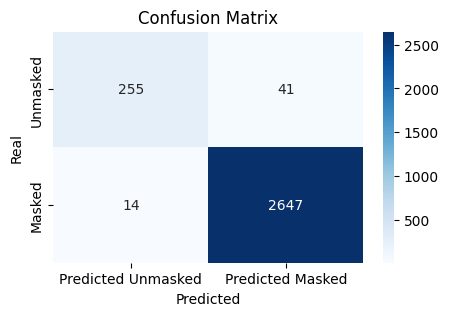

In [12]:
cf = evaluate_with_confusion_matrix(model, test_dataset)
plot_confusion_matrix(cf)

### Save results

In [13]:
results = {
    "batch_size" : batch_size,
    "learning_rate" : learning_rate,
    "opt_databalance" : opt_databalance,
    "epochs" : num_epochs,
    "average_dice": average_dice,
    "cm": cf.flatten().tolist()
}

with open(model_results_path, "w") as archivo_json:
    json.dump(results, archivo_json)

### Plot results

1/1 [==============================] - 0s 57ms/step


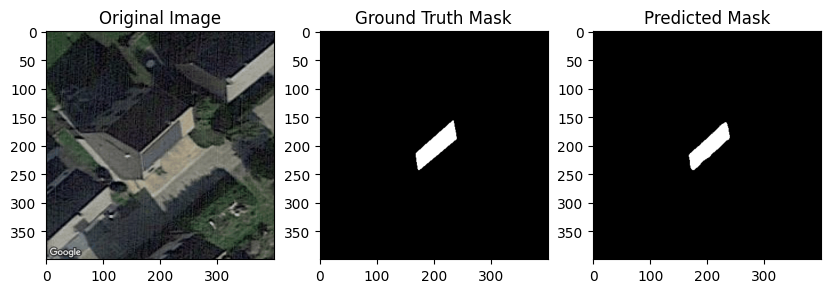

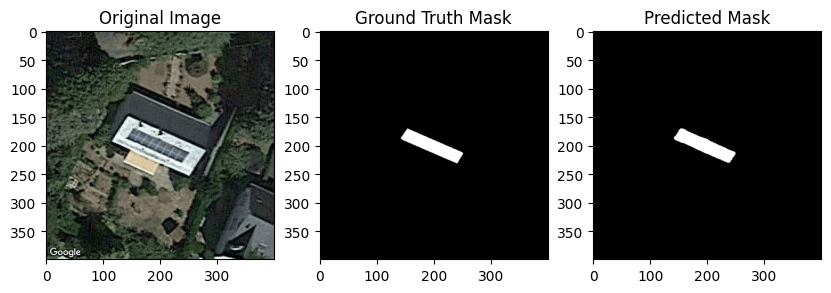

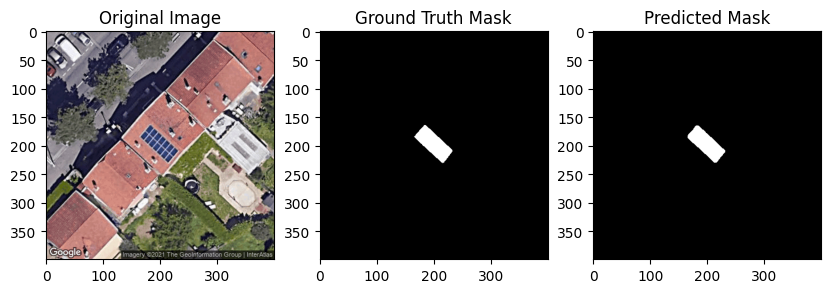

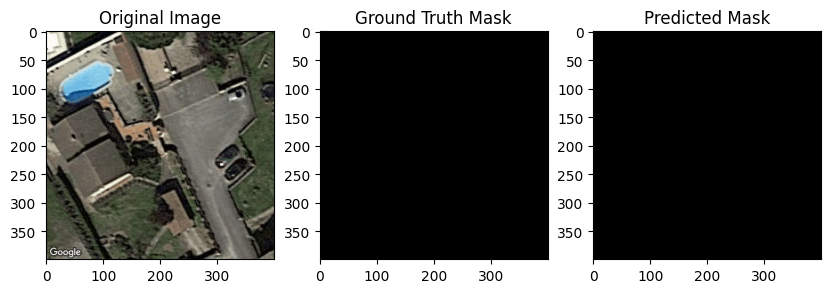

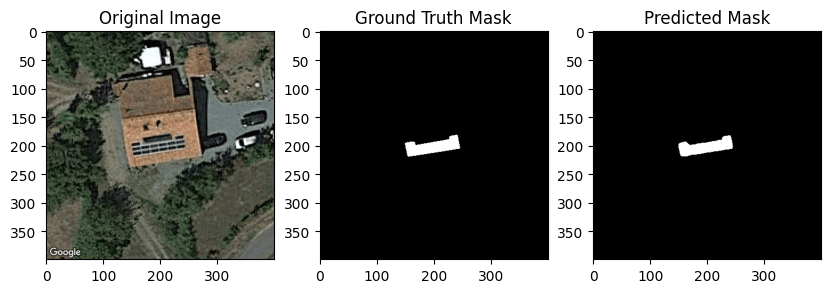

In [14]:
visualize_predictions(model, test_dataset, path_save_imgs_test, num_samples=5)